In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sts
import seaborn as sns
sns.set()

In [2]:
np.random.seed(108727)
x0 = np.random.normal(0, 1, size = 5)
print x0

[-0.05996209  1.47035113 -0.91506563 -0.29584768  2.57572058]


In [3]:
def objective(x):
    A = np.exp(-b*(x[:,np.newaxis] - x.T)**2) + 1e-8 * np.identity(x.shape[0])
    H = np.ones([x.shape[0],1])
    T = (1./np.sqrt(2*b+1) * np.exp(-(b/(2*b+1))*x**2))
    beta = np.linalg.solve(A,H)
    alpha = 1 - np.matmul(T, beta)
    return - np.dot(T, np.linalg.solve(A,T)) + np.matmul(alpha, np.linalg.solve(np.matmul(H.T, beta), alpha.T))

In [4]:
b = 1.5
res = minimize(objective, x0, method='nelder-mead',
               options={'xtol': 1e-12, 'disp': True, 'maxiter':5000})
print res.x

Optimization terminated successfully.
         Current function value: -0.377409
         Iterations: 629
         Function evaluations: 1087
[ -7.84325381e-09   8.21357450e-01  -1.73130000e+00  -8.21357476e-01
   1.73129993e+00]


In [5]:
norm = sts.norm(0, 1)
z = np.linspace(-5,5,100)

In [6]:
# Collect data - evaluate the simulator
f = norm.pdf(res.x)
x = res.x

# Compute the predicted GP parameters beta and sigma
A = np.exp(-b*(x[:,np.newaxis] - x.T)**2) + 1e-8 * np.identity(x.shape[0])
H = np.ones([x.shape[0],1])
beta = np.linalg.solve(np.dot(H.T,np.linalg.solve(A,H)), np.matmul(H.T, np.linalg.solve(A,f)))
d = np.dot(f,np.linalg.solve(A,f)) - np.dot(f, np.linalg.solve(A, np.matmul(H, beta)))

In [7]:
# Compute the predictions for untested data
h = np.ones(z.shape[0])
t = np.exp(-b*(z[:,np.newaxis] - x)**2).T
m = h * beta + np.matmul(t.T, np.linalg.solve(A, (f - (H * beta).T).T)).T
c = np.ones([z.shape[0],1]) - np.matmul(t.T, np.linalg.solve(A,H))
s2 = d/(x.shape[0]-1-2)  * (np.ones(z.shape[0]) - np.sum(t*np.linalg.solve(A,t), axis=0) + c.T * np.linalg.solve(np.matmul(H.T, np.linalg.solve(A,H)), c.T))

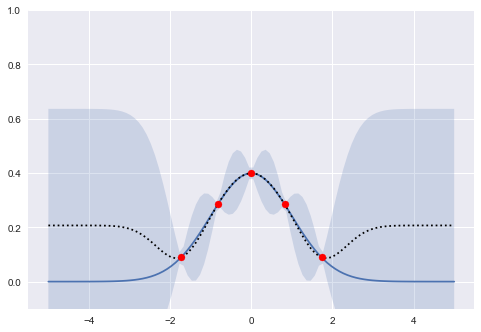

In [8]:
plt.plot(z, norm.pdf(z), zorder = 1, label = 'norm density');
plt.scatter(res.x, norm.pdf(res.x), c = 'r', zorder = 2);
plt.plot(z, m.T, ':k', zorder = 1, label = 'predicted');
plt.fill_between(z, np.array(m - 2 * np.sqrt(s2))[0], np.array(m + 2 * np.sqrt(s2))[0], alpha = .2);
plt.ylim([-.1, 1]);

In [9]:
T = np.exp(-b/(2*b+1) * res.x**2)/np.sqrt(2*b+1)
k = np.matmul(T,np.linalg.solve(A,f)) + (1 - np.matmul(T, np.linalg.solve(A,H))) * np.linalg.solve(np.matmul(H.T, np.linalg.solve(A,H)), np.matmul(H.T, np.linalg.solve(A,f)))
s = d/(x.shape[0]-3) * (1./np.sqrt(4*b+1)+objective(res.x))

In [10]:
print 'Estimated mean: %s'%(k[0])
print 'True value    : %s'%(np.sqrt(np.pi)/(2*np.pi))
print 'Error         : %s'%(np.abs(np.sqrt(np.pi)/(2*np.pi)-k[0]))
print 'Estimated error: %s'%(np.sqrt(s))

Estimated mean: 0.285357492574
True value    : 0.282094791774
Error         : 0.0032627007999
Estimated error: 0.0044356010767


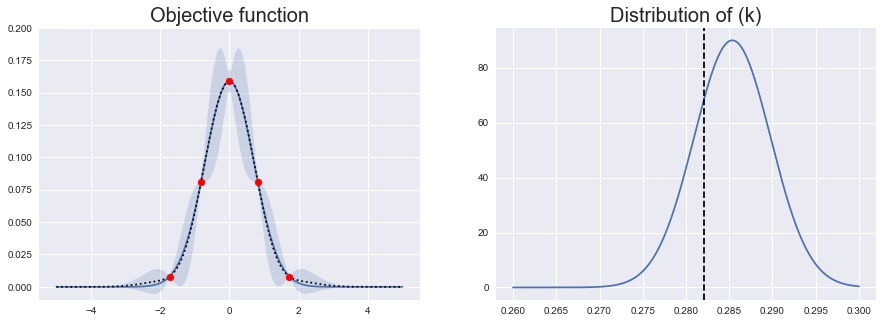

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
ax1.plot(z, norm.pdf(z)**2, zorder = 1, label = 'norm density');
ax1.scatter(res.x, norm.pdf(res.x)**2, c = 'r', zorder = 2);
ax1.plot(z, (norm.pdf(z) * m).T, ':k', zorder = 1, label = 'predicted');
ax1.fill_between(z, np.array((m-2*np.sqrt(s2))*norm.pdf(z))[0], np.array((m + 2 * np.sqrt(s2)) * norm.pdf(z))[0], alpha = .2);
ax1.set_ylim([-.01, .2]);
ax1.set_title('Objective function', Fontsize = 20)

integral = sts.norm(k[0], np.sqrt(s));
ax2.plot(np.linspace(0.26,.30,1000), integral.pdf(np.linspace(0.26,.30,1000)));
ax2.axvline(x = np.sqrt(np.pi)/(2*np.pi), linestyle = '--', color = 'k');
ax2.set_title('Distribution of (k)', Fontsize = 20);

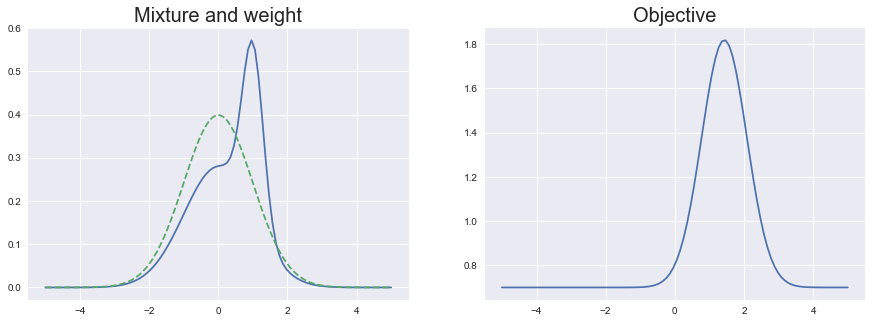

In [12]:
a = .3
mu = 2.
mu = 1.

f1 = sts.norm(0,1)
f2 = sts.norm(mu,0.3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
ax1.plot(z, (1-a) * f1.pdf(z) + a * f2.pdf(z) );
ax1.plot(z, norm.pdf(z), '--');
ax1.set_title('Mixture and weight', Fontsize = 20)

ax2.plot(z, 1-a+a*(0.3)**(-0.5)*np.exp(-1./6 * (10.*(z-mu)**2 - 3.*z**2)))
ax2.set_title('Objective', Fontsize = 20)

In [13]:
def mixobj(z):
    return 1-a+a*(0.3)**(-0.5)*np.exp(-1./6 * (10.*(z-mu)**2 - 3.*z**2))

In [14]:
# Collect data - evaluate the simulator
f = mixobj(res.x)
x = res.x

# Compute the predicted GP parameters beta and sigma
A = np.exp(-b*(x[:,np.newaxis] - x.T)**2) + 1e-8 * np.identity(x.shape[0])
H = np.ones([x.shape[0],1])
beta = np.linalg.solve(np.dot(H.T,np.linalg.solve(A,H)), np.matmul(H.T, np.linalg.solve(A,f)))
d = np.dot(f,np.linalg.solve(A,f)) - np.dot(f, np.linalg.solve(A, np.matmul(H, beta)))

In [15]:
# Compute the predictions for untested data
h = np.ones(z.shape[0])
t = np.exp(-b*(z[:,np.newaxis] - x)**2).T
m = h * beta + np.matmul(t.T, np.linalg.solve(A, (f - (H * beta).T).T)).T
c = np.ones([z.shape[0],1]) - np.matmul(t.T, np.linalg.solve(A,H))
s2 = d/(x.shape[0]-1-2)  * (np.ones(z.shape[0]) - np.sum(t*np.linalg.solve(A,t), axis=0) + c.T * np.linalg.solve(np.matmul(H.T, np.linalg.solve(A,H)), c.T))

In [16]:
T = np.exp(-b/(2*b+1) * res.x**2)/np.sqrt(2*b+1)
k = np.matmul(T,np.linalg.solve(A,f)) + (1 - np.matmul(T, np.linalg.solve(A,H))) * np.linalg.solve(np.matmul(H.T, np.linalg.solve(A,H)), np.matmul(H.T, np.linalg.solve(A,f)))
s = d/(x.shape[0]-3) * (1./np.sqrt(4*b+1)+objective(res.x))

In [17]:
print 'Estimated mean : %s'%(k[0])
print 'True value     : %s'%(1.)
print 'Error          : %s'%(np.abs(1.-k[0]))
print 'Estimated error: %s'%(np.sqrt(s))

Estimated mean : 1.00570593356
True value     : 1.0
Error          : 0.00570593355613
Estimated error: 0.0142023553918


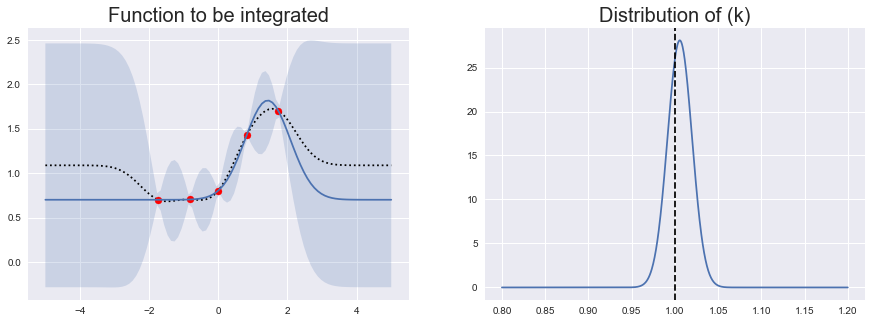

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5));
ax1.scatter(res.x, mixobj(res.x), c = 'r', zorder = 2);
ax1.plot(z, mixobj(z))
ax1.plot(z, m.T, ':k', zorder = 1, label = 'predicted');
ax1.fill_between(z, np.array(m - 2 * np.sqrt(s2))[0], np.array(m + 2 * np.sqrt(s2))[0], alpha = .2);
ax1.set_title('Function to be integrated', Fontsize = 20);

integral = sts.norm(k[0], np.sqrt(s));
ax2.plot(np.linspace(0.8,1.2,1000), integral.pdf(np.linspace(0.8,1.20,1000)));
ax2.axvline(x = 1, linestyle = '--', color = 'k');
ax2.set_title('Distribution of (k)', Fontsize = 20);